In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 24

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2022-09-18 22:48:05.326849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
43/46 [===========================>..] - ETA: 0s - loss: 3.2089 - accuracy: 0.0538 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
46/46 [==============================] - 1s 6ms/step - loss: 3.2071 - accuracy: 0.0548 - val_loss: 3.1429 - val_accuracy: 0.0657
Epoch 2/1000
40/46 [=========================>....] - ETA: 0s - loss: 3.1412 - accuracy: 0.0688
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
46/46 [==============================] - 0s 2ms/step - loss: 3.1390 - accuracy: 0.0681 - val_loss: 3.0839 - val_accuracy: 0.0942
Epoch 3/1000
42/46 [==========================>...] - ETA: 0s - loss: 3.0678 - accuracy: 0.0846
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
46/46 [==============================] - 0s 2ms/step - loss: 3.0636 - accuracy: 0.0864 - val_loss: 2.9700 - val_accuracy: 0.1076
Epoch 4/1000
42/46 [==========================>...] - ETA: 0s - loss: 2.9692 - accuracy: 0.1086


In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

16/16 [==============================] - 0s 1ms/step - loss: 1.0520 - accuracy: 0.6824


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 77ms/step
[9.8441951e-03 3.7331916e-03 5.8540082e-01 7.4049056e-02 1.4432596e-01
 1.0751863e-01 1.4885111e-12 9.3267317e-11 7.7393779e-05 2.6284510e-09
 2.5198266e-02 3.1411017e-07 7.5624499e-08 3.1200184e-02 4.9447756e-13
 4.7325275e-06 1.2960995e-04 1.3802820e-02 3.9489805e-03 7.6801308e-07
 7.6940787e-06 3.6591353e-04 3.7238930e-04 1.8960120e-05]
2


# Confusion matrix

61/61 [==============================] - 0s 847us/step


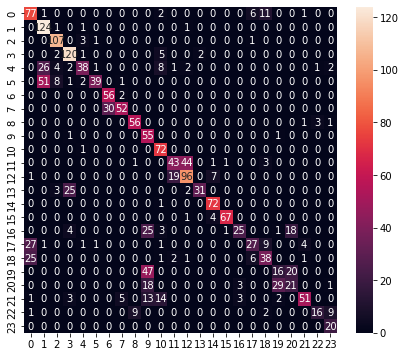

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.79      0.67        98
           1       0.61      0.98      0.75       127
           2       0.86      0.96      0.90       112
           3       0.77      0.92      0.84       130
           4       0.81      0.45      0.58        85
           5       0.93      0.38      0.54       102
           6       0.65      0.97      0.78        58
           7       0.87      0.63      0.73        82
           8       0.85      0.92      0.88        61
           9       0.35      0.96      0.51        57
          10       0.67      0.99      0.80        73
          11       0.66      0.46      0.54        93
          12       0.65      0.78      0.71       123
          13       0.94      0.51      0.66        61
          14       0.86      0.99      0.92        73
          15       0.97      0.93      0.95        72
          16       0.81      0.32      0.46        77
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/g7/z_b90041623_90_9qd8xq9l80000gn/T/tmp2tv6sjol/assets


2022-09-18 22:48:36.903158: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-18 22:48:36.903178: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-18 22:48:36.906738: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/g7/z_b90041623_90_9qd8xq9l80000gn/T/tmp2tv6sjol
2022-09-18 22:48:36.910992: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-09-18 22:48:36.911010: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/g7/z_b90041623_90_9qd8xq9l80000gn/T/tmp2tv6sjol
2022-09-18 22:48:36.919814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-09-18 22:48:36.921941: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-09-18 22:48:37.003397: I tensorflow/cc/saved_model/loader.

7368

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.16 ms, sys: 1.69 ms, total: 2.85 ms
Wall time: 2.11 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.8441821e-03 3.7331819e-03 5.8540118e-01 7.4049003e-02 1.4432578e-01
 1.0751864e-01 1.4885148e-12 9.3267373e-11 7.7393684e-05 2.6284477e-09
 2.5198234e-02 3.1411005e-07 7.5624470e-08 3.1200187e-02 4.9447789e-13
 4.7325307e-06 1.2960978e-04 1.3802812e-02 3.9489791e-03 7.6801206e-07
 7.6940678e-06 3.6591341e-04 3.7238884e-04 1.8960096e-05]
2
